In [1]:
import os
os.getcwd()

import sys
sys.path.append('/Users/glw33/source/project')

from project.defect_species import Defect_Species
from project.set_of_sites import Set_of_Sites
from project.constants import boltzmann_eV
from project.onedefect_onedopant_calculations import *
from project.general_calculations import *

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rc
%matplotlib inline

In [2]:
data = '/Users/glw33/ipython_notebooks/Gd_Ce02_space_charge_systems/Input_Data/Gd_CeO2_111_data.txt'

In [3]:
alpha = 0.0005
conv = 1e-8
grid_x_min = -6.0e-9
grid_x_max = +6.0e-9
bulk_region_x_min = 1.4e-8 
bulk_region_x_max = 1.8e-8

dielectric = 55

index = 111
b = 7.65327e-10
c = 7.65327e-10

temp_sinter = [1173.15, 1273.15, 1373.15, 1473.15, 1573.15, 1673.15, 1773.15, 1873.15, 1973.15]

valence = [ +2.0, -1.0 ]
site_labels = [ 'O', 'Ce' ]
defect_labels = ['Vo', 'Gd']
mole_fractions = np.array([ [ 0.01, 0.04 ], [ 0.0125, 0.05 ], [ 0.025, 0.1 ], [ 0.0375, 0.15 ], [ 0.05, 0.2 ], [ 0.0625, 0.25 ], [ 0.075, 0.3 ], [ 0.0875, 0.35 ] ])

In [4]:
# Empty lists are created to store the slope and intercept from the linear regression.
slope_list = []
intercept_list = []

# fixed refers to whether the immobile defect is to be fixed to its bulk mole fraction.
fixed = False

# Loops over temperature.
for t in temp_sinter:
    # Creates an empty list to store the uncorrected output mole fractions.
    avg_Vo_molfracs = []
    # Loops over input mole fractions. 
    for m in mole_fractions:
        # From the system specific constants a defect species is produced by zipping together the defect label, valence and mole fraction for each species.
        defect_species = { l : Defect_Species( l, v, m ) for l, v, m in zip( defect_labels, valence, m) }
        data_file = open( data, 'r')
        # Each line in the input data file is read and split into individual strings.
        # These individual strings are then created into sites providing the second element on each line ( the x coordinate)
        # is within the range defined. These sites are then compiled into a list 'all_sites'
        input_data = [ line.split() for line in data_file.readlines() ]
        input_data = [ line for line in input_data if ( float(line[1]) > bulk_region_x_min and float(line[1]) < bulk_region_x_max ) ] 
        all_sites = Set_of_Sites( [ site_from_input_file( line, defect_species ) for line in input_data ] )
        # This fixes the immobile defect to its bulk mole fraction throughout the calculation. Assuming Mott-Schottky conditions.
        for site in all_sites.subset( 'Ce' ):
            site.defect_with_label('Gd').fixed = False
        # Runs the Poisson-Boltzmann solver and returns the output mole fraction. 
        avg_Vo_MF = calculate_average_molefraction( t, bulk_region_x_min, bulk_region_x_max, b, c, index, alpha, conv, all_sites, site_labels, 'dirichlet')
        avg_Vo_molfracs.append( avg_Vo_MF ) 
    # the linear regression is performed on the input and output mole fractions. 
    slope, intercept, rvalue, pvalue, stderr = stats.linregress( mole_fractions[:,0], avg_Vo_molfracs )
    slope_list.append( slope )
    intercept_list.append( intercept )

# The percentage gadolinium content is defined here and is converted into a desired mole fraction for the 'real' calculation.
percentage_Gd = 10
desired_mobile_defect_MF = ( percentage_Gd / 100 ) / 4
# The input mole fractions that will give the desired output mole fractions for the given percentage gadolinium content are calculated from the linear regreassion results.
# This is done for each temperature and is compiled into an array overwriting the original mole_fractions array.
mole_fractions = np.array( [ MF( desired_mobile_defect_MF, s, i ) for s, i in zip( slope_list, intercept_list ) ] )

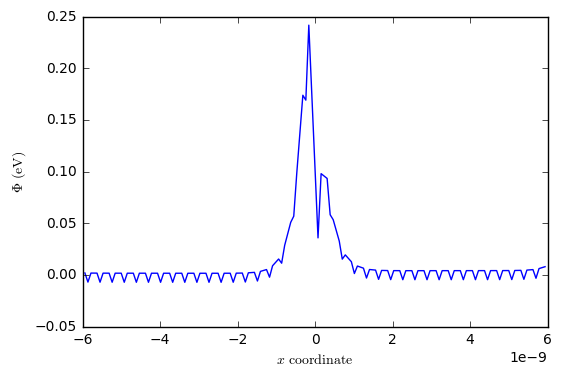

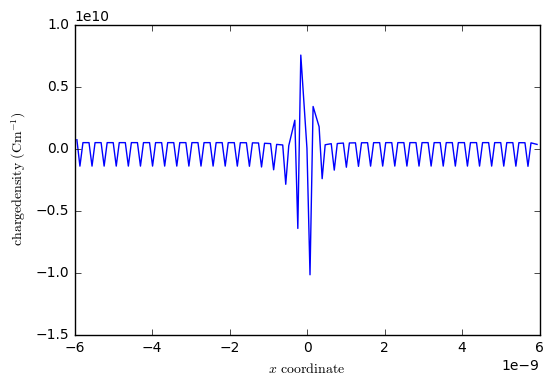

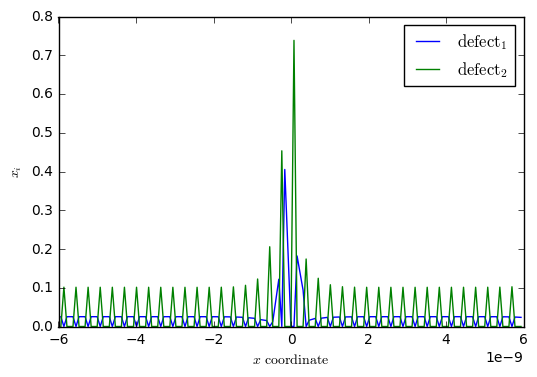

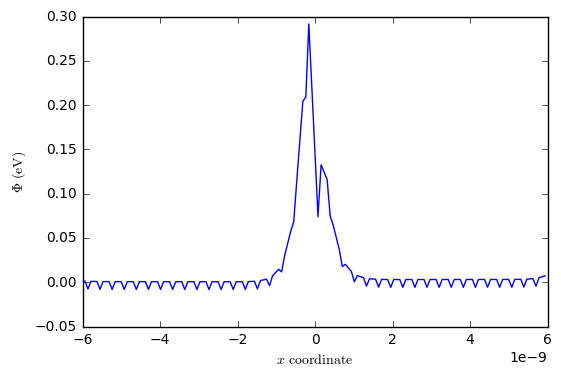

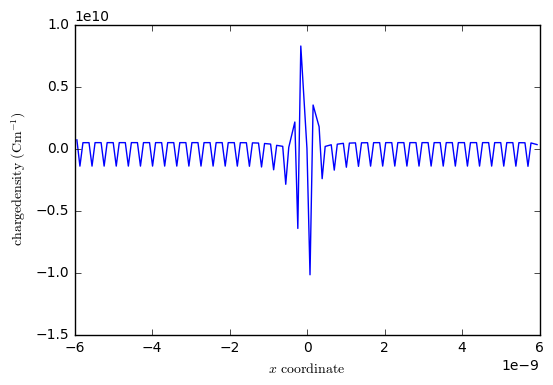

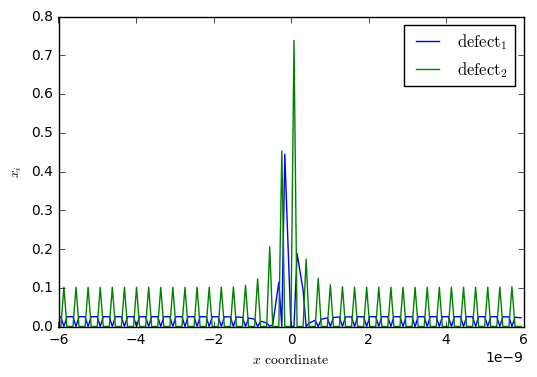

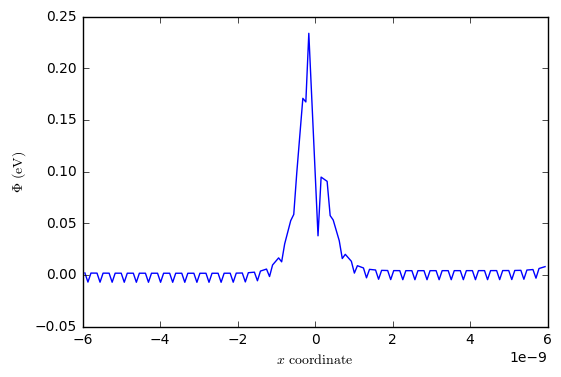

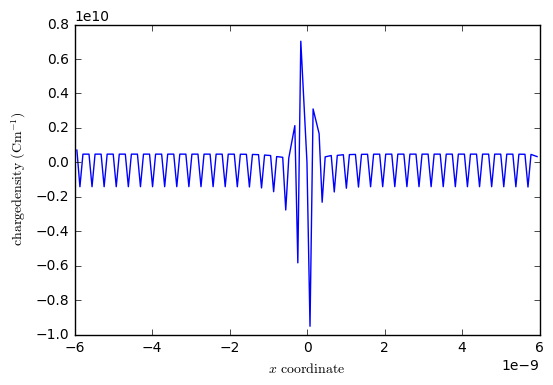

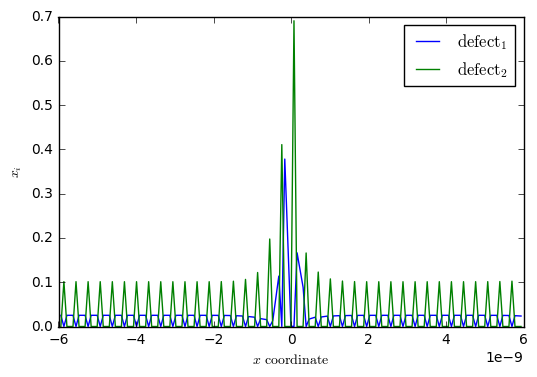

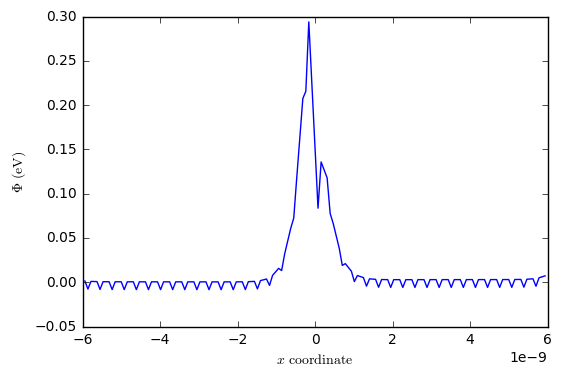

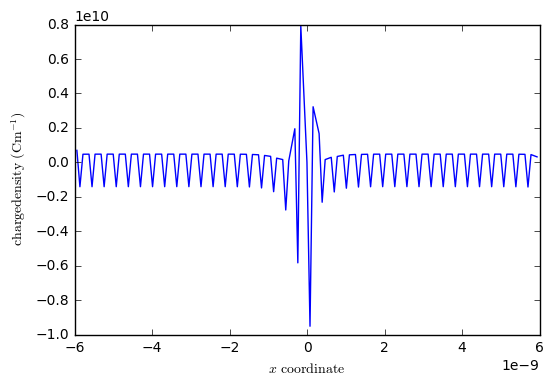

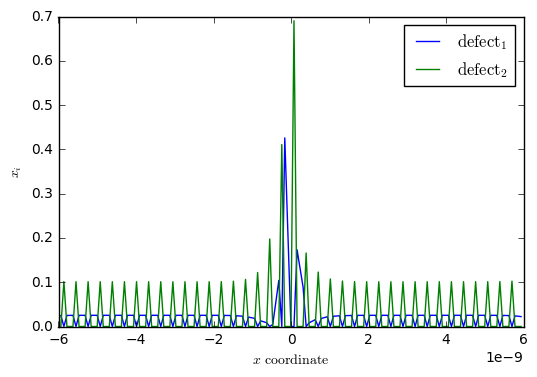

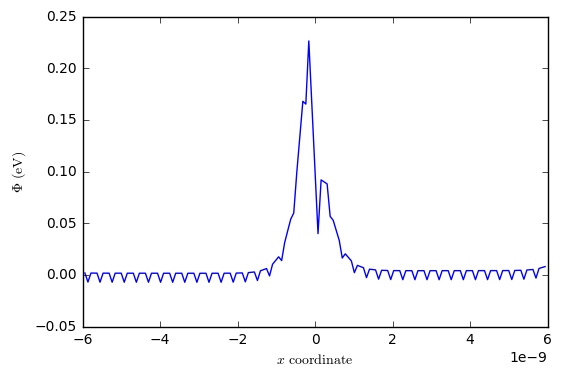

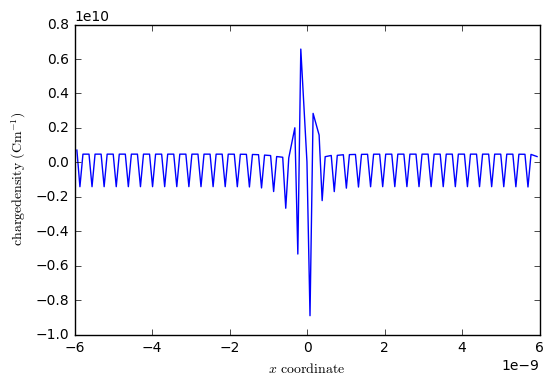

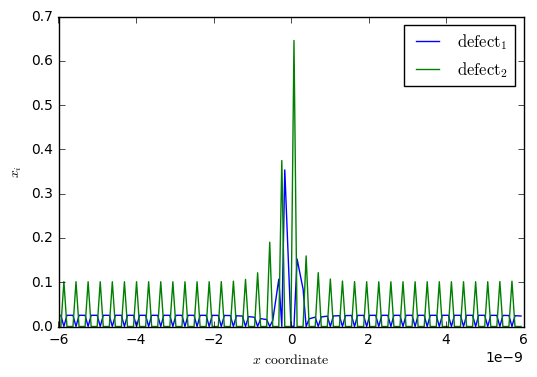

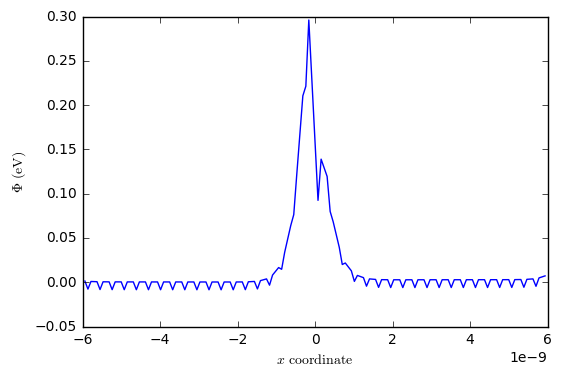

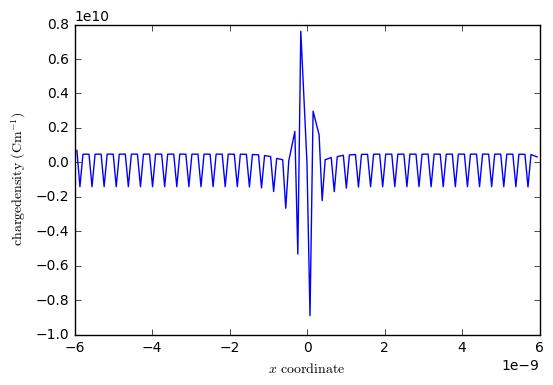

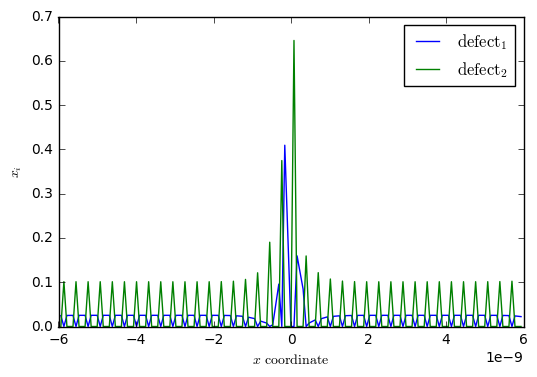

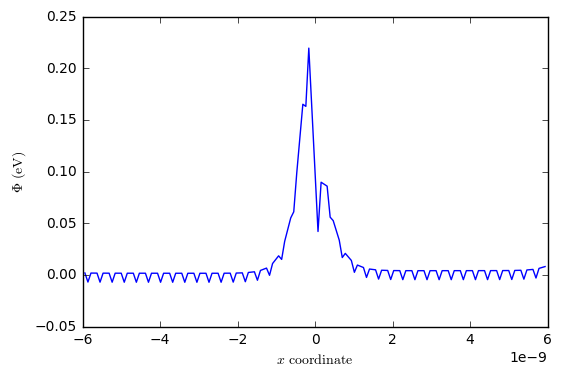

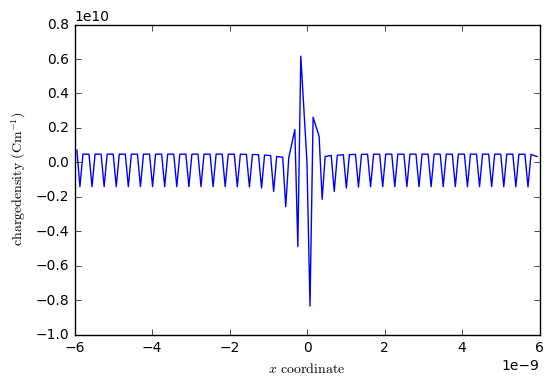

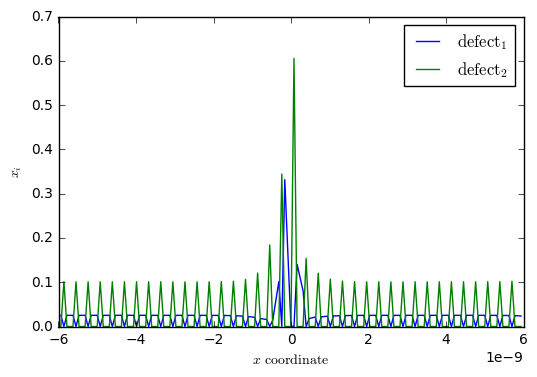

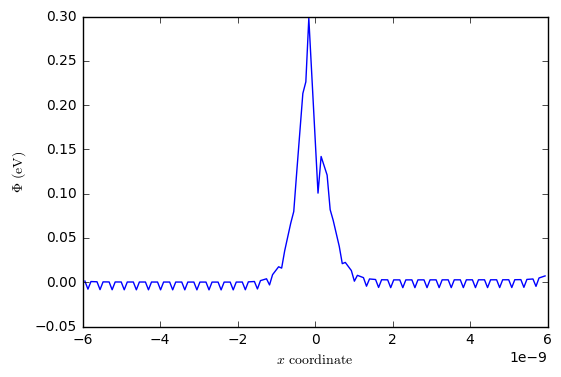

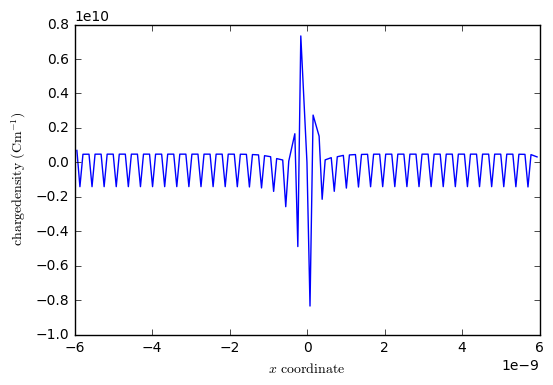

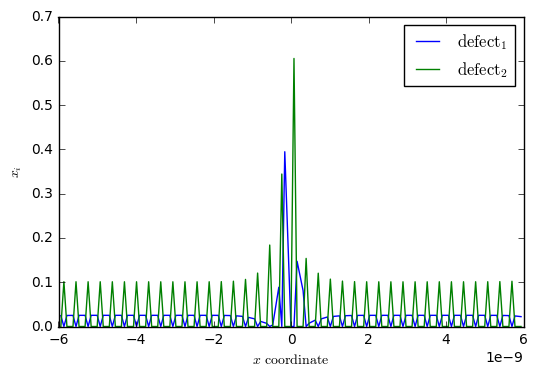

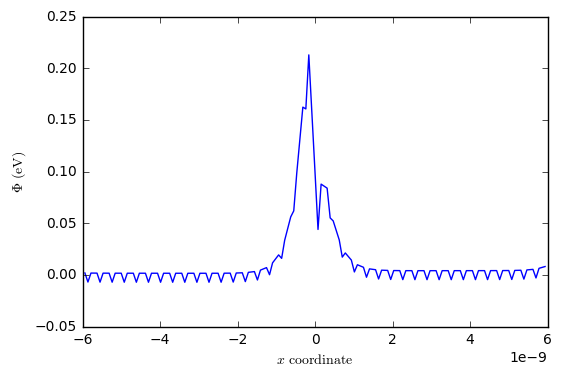

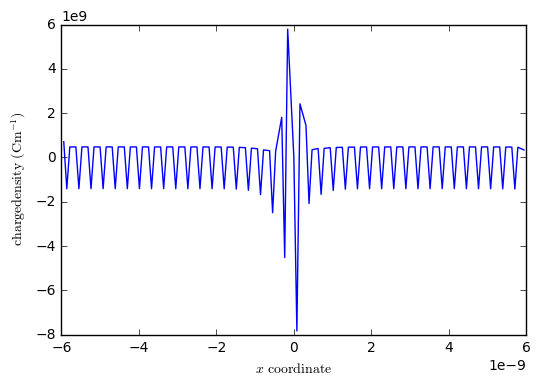

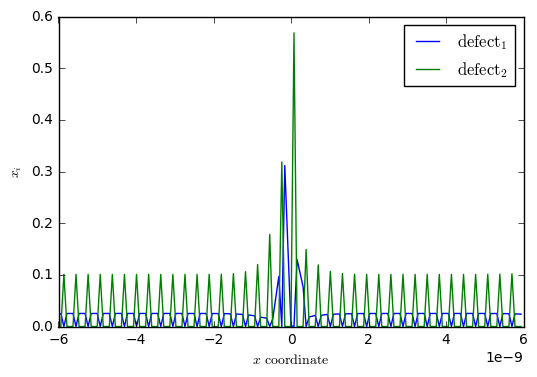

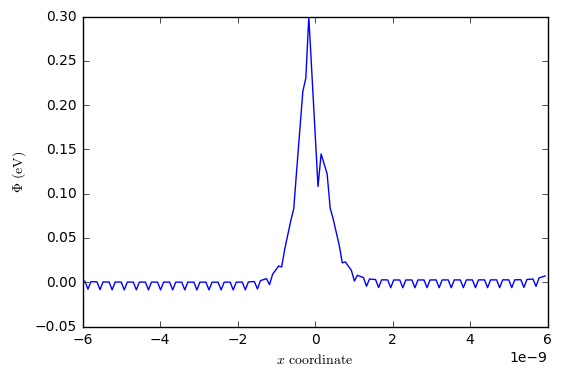

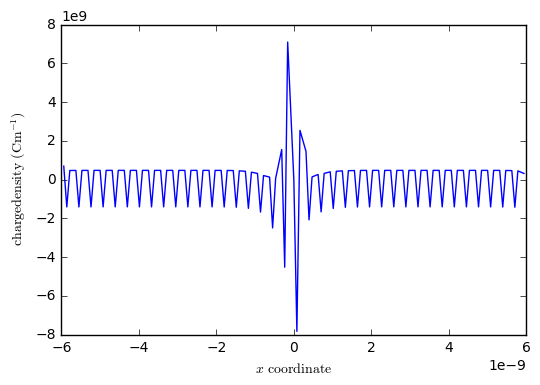

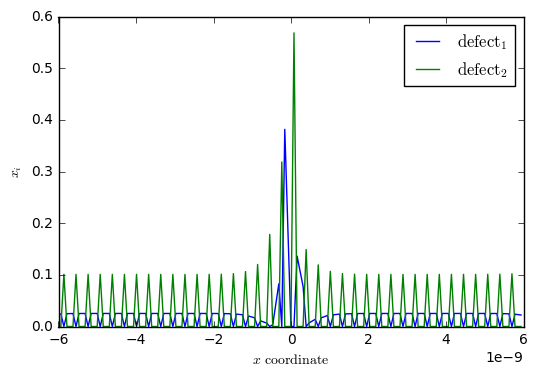

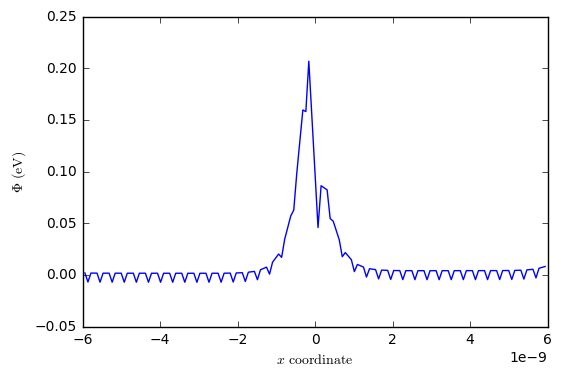

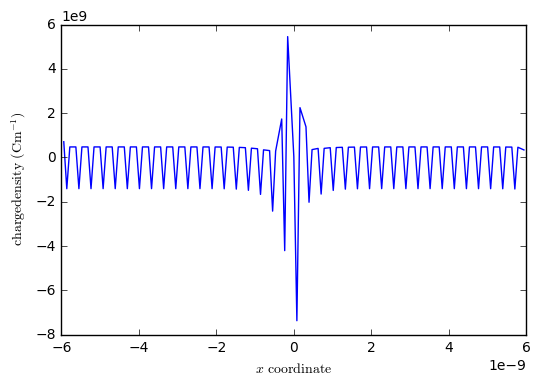

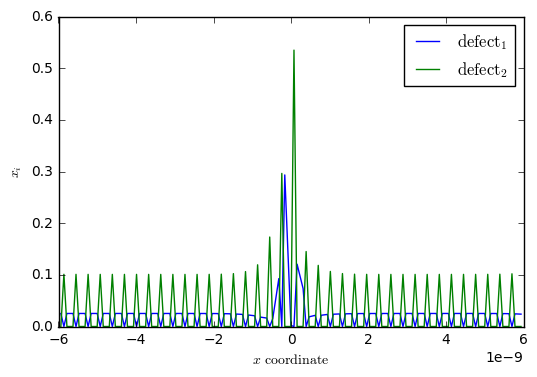

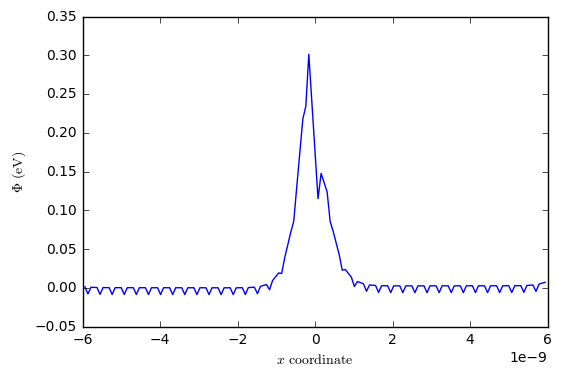

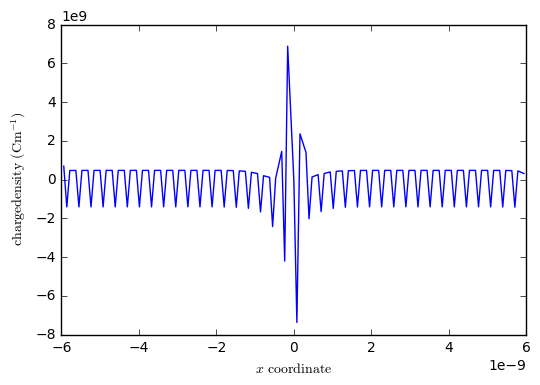

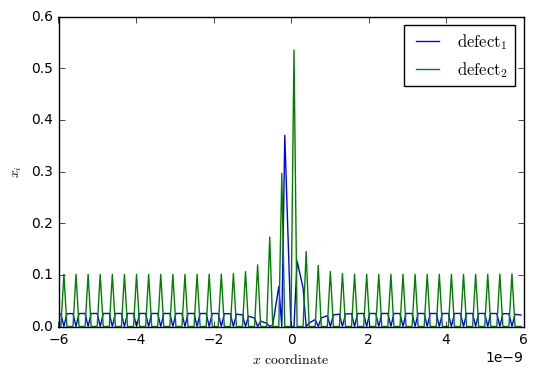

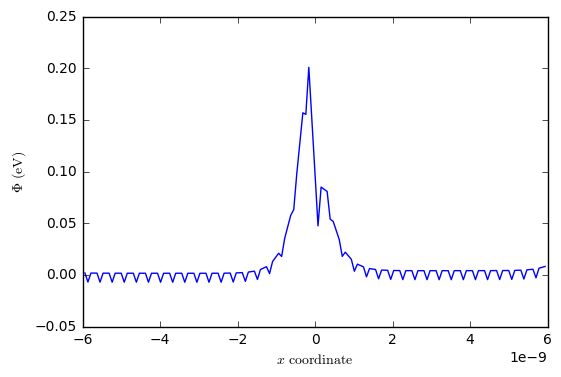

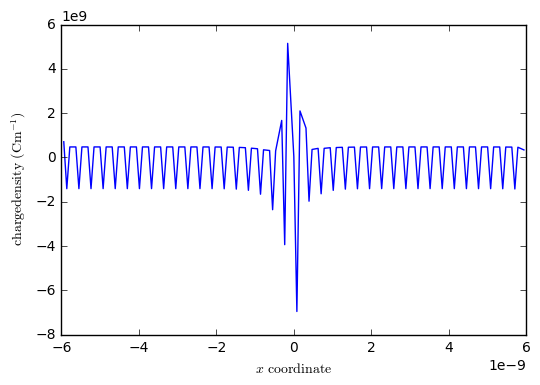

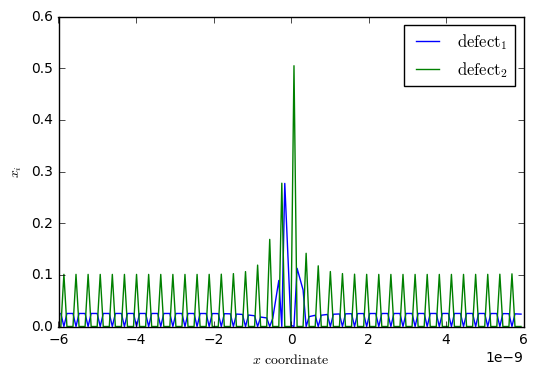

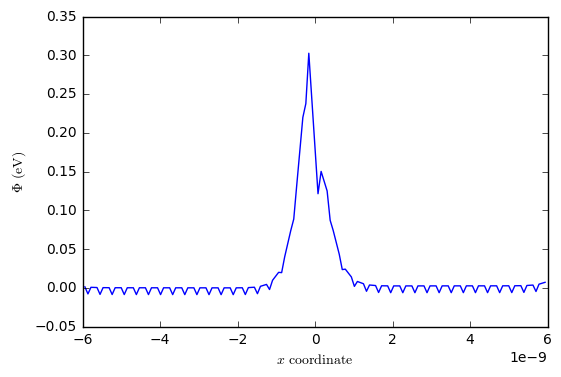

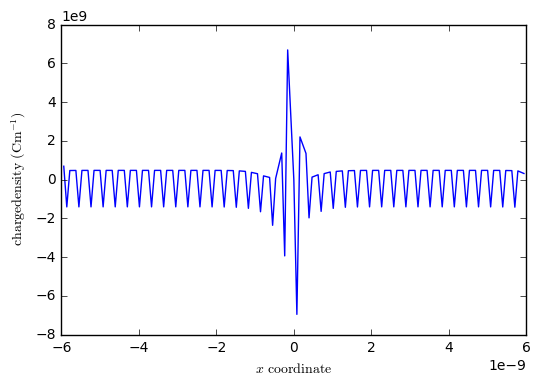

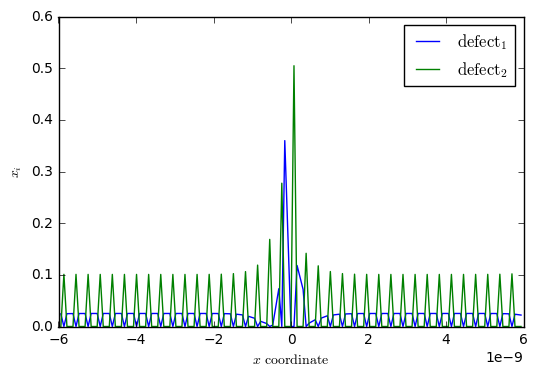

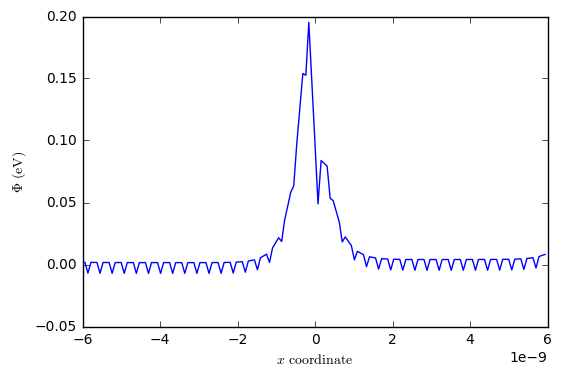

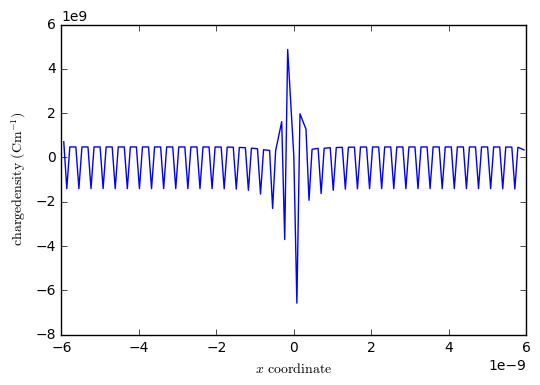

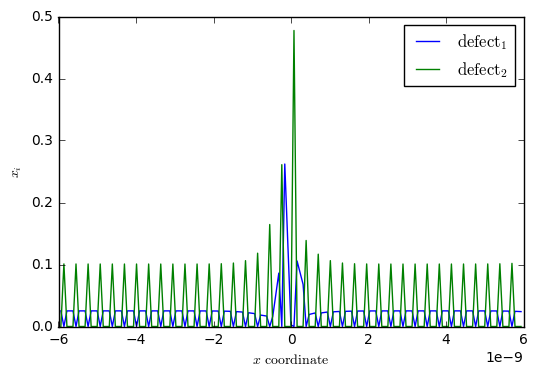

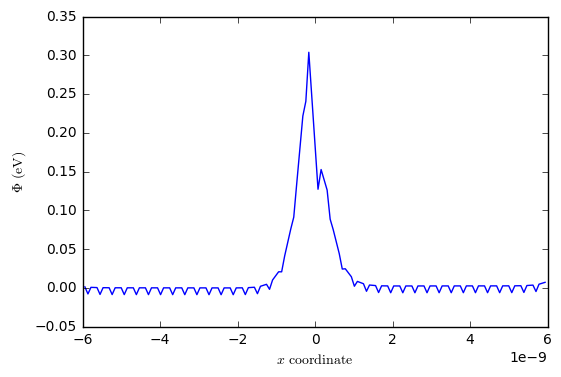

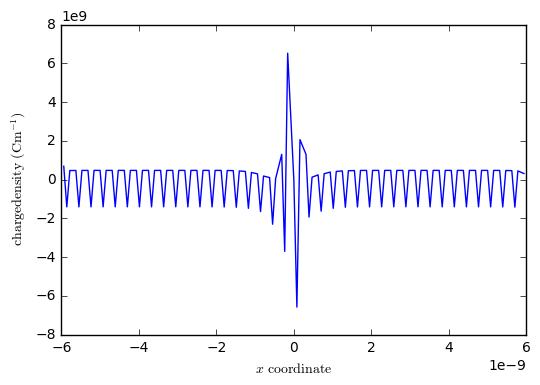

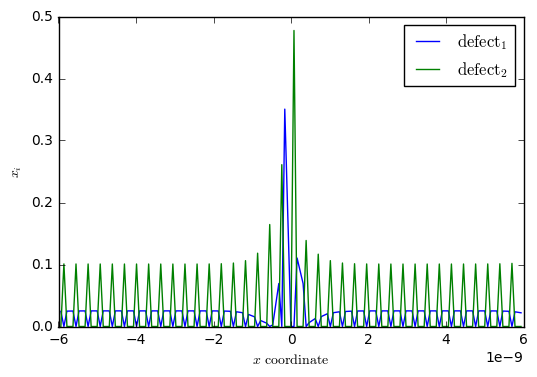

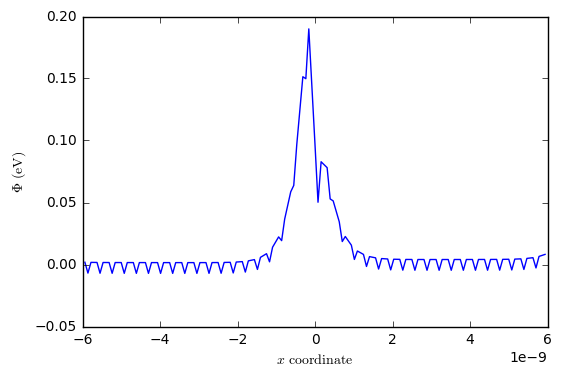

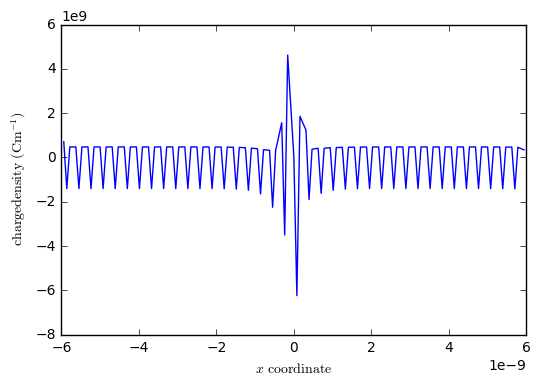

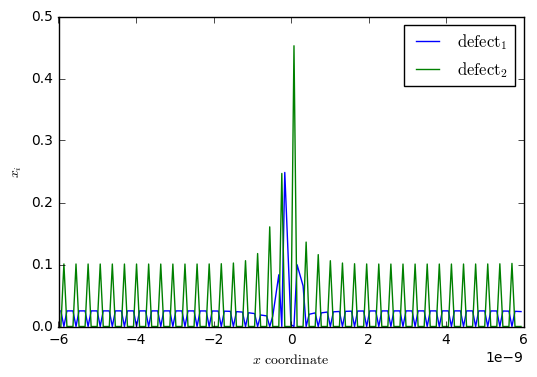

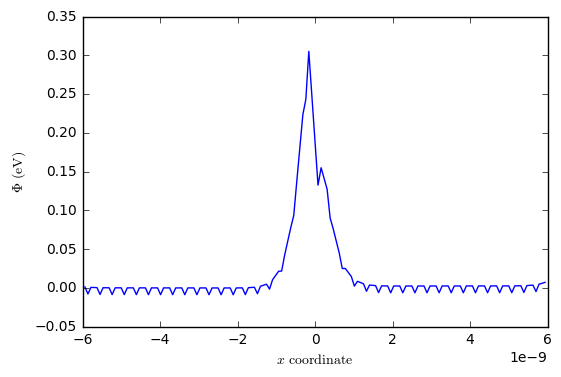

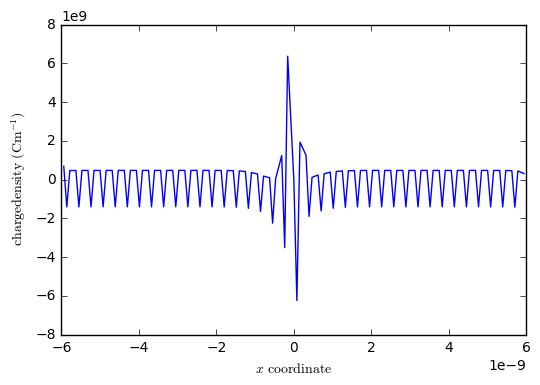

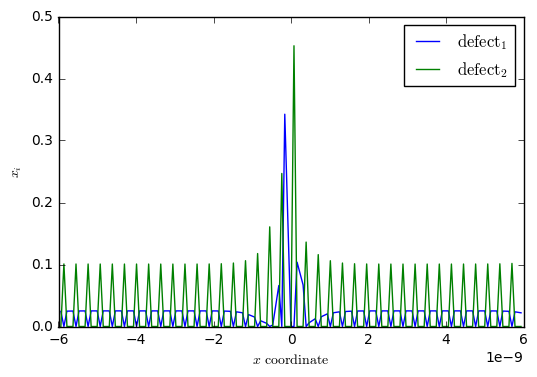

In [5]:
# Empty lists are created to store the calculated resistivity ratio, the defect density in the bulk and the space charge potential for each temperature.
ratios = []
bulk_density_list = []
max_phi_list = []
ratios_2 = []
bulk_density_list_2 = []
max_phi_list_2 = []

# Each temperature and its corresponding input mole fraction are zipped together. These are then looped over for each calculation.
for t, m in zip( temp_sinter, mole_fractions ):
    fixed = False
    # From the system specific constants a defect species is produced by zipping together the defect label, valence and mole fraction for each species.
    defect_species = { l : Defect_Species( l, v, m ) for l, v, m in zip( defect_labels, valence, m) }
    data_file = open( data, 'r')
    # Each line in the input data file is read and split into individual strings.
    # These individual strings are then created into sites providing the second element on each line ( the x coordinate)
    # is within the range of values either side of the grain boundary defined. These sites are then compiled into a list 'all_sites'
    input_data = [ line.split() for line in data_file.readlines() ]
    input_data = [ line for line in input_data if ( float(line[1]) > grid_x_min and float(line[1]) < grid_x_max ) ] 
    all_sites = Set_of_Sites( [ site_from_input_file( line, defect_species ) for line in input_data ] )
    # This fixes the immobile defect to its bulk mole fraction throughout the calculation. Assuming Mott-Schottky conditions.
    for site in all_sites.subset( 'Ce' ):
        site.defect_with_label('Gd').fixed = False
    # The Poisson-Boltzmann solver is run and returns the site explicit properties.
    # These properties are stacked into a table and saved in a .dat file.
    grid, phi, rho, probabilities, resistivity_ratio, Vo_mole_fraction, Gd_mole_fraction, bulk_density, niter = calculate_GB_properties( t, grid_x_min, grid_x_max, b, c, index, alpha, conv, desired_mobile_defect_MF, all_sites, site_labels, 'dirichlet'  )
    site_data = np.column_stack( ( grid.x, phi, rho, probabilities, Vo_mole_fraction, Gd_mole_fraction ) )
    site_data_filename = '{}_GC_sintering_site_data_percentGd{}_temp{}_bulkfixed{}.dat'.format( index, percentage_Gd, t, fixed )
    header = ' x, phi, rho, probabilities, Vo_MF, Gd_MF, temp, Gd_fixed_to_bulk '
    np.savetxt( site_data_filename, site_data, header = header )
    # The calculated resistivity ratio, the defect density in the bulk and the space charge potential for each temperature are stored in the defined lists.
    ratios.append( resistivity_ratio )   
    bulk_density_list.append( bulk_density )
    max_phi_list.append( max(phi) )
    
    plt.plot(grid.x, phi)
    plt.xlabel( '$x$ $\mathrm{coordinate}$' )
    plt.ylabel('$\Phi$ $\mathrm{( eV )}$')
    plt.show()

    plt.plot(grid.x, rho)
    plt.xlabel( '$x$ $\mathrm{coordinate}$'  )
    plt.ylabel(' $\mathrm{charge density}$ $(\mathrm{C m}^{-1})$')
    plt.show()

    plt.plot(grid.x, Vo_mole_fraction, label = '$\mathrm{defect_1}$')
    plt.plot(grid.x, Gd_mole_fraction, label = '$\mathrm{defect_2}$')
    plt.xlabel( '$x$ $\mathrm{coordinate}$'  )
    plt.ylabel('$x_{i}$')
    plt.legend()
    plt.show()

    # Empty lists are created to store the calculated resistivity ratio, the defect density in the bulk and the space charge potential for each temperature.

    # This fixes the immobile defect to its bulk mole fraction throughout the calculation. Assuming Mott-Schottky conditions.
    fixed = True
    for site in all_sites.subset( 'Ce' ):
        site.defect_with_label('Gd').mole_fraction = site.probabilities( phi_at_x( phi, grid.x, site.x ), t )[0]
        site.defect_with_label('Gd').fixed = fixed
    temp = 773.15
    # The Poisson-Boltzmann solver is run and returns the site explicit properties.
    # These properties are stacked into a table and saved in a .dat file.
    grid, phi, rho, probabilities, resistivity_ratio, Vo_mole_fraction, Gd_mole_fraction, bulk_density, niter = calculate_GB_properties( temp, grid_x_min, grid_x_max, b, c, index, alpha, conv, desired_mobile_defect_MF, all_sites, site_labels, 'dirichlet'  )
    site_data = np.column_stack( ( grid.x, phi, rho, probabilities, Vo_mole_fraction, Gd_mole_fraction ) )
    site_data_filename = '{}__sintering_part_two_site_data_percentGd{}_temp{}_sintertemp{}_bulkfixed{}.dat'.format( index, percentage_Gd, temp, t, fixed )
    header = ' x, phi, rho, probabilities, Vo_MF, Gd_MF, temp, Gd_fixed_to_bulk '
    np.savetxt( site_data_filename, site_data, header = header )
    # The calculated resistivity ratio, the defect density in the bulk and the space charge potential for each temperature are stored in the defined lists.
    ratios_2.append( resistivity_ratio )   
    bulk_density_list_2.append( bulk_density )
    max_phi_list_2.append( max(phi) )

    plt.plot(grid.x, phi)
    plt.xlabel( '$x$ $\mathrm{coordinate}$' )
    plt.ylabel('$\Phi$ $\mathrm{( eV )}$')
    plt.show()

    plt.plot(grid.x, rho)
    plt.xlabel( '$x$ $\mathrm{coordinate}$'  )
    plt.ylabel(' $\mathrm{charge density}$ $(\mathrm{C m}^{-1})$')
    plt.show()

    plt.plot(grid.x, Vo_mole_fraction, label = '$\mathrm{defect_1}$')
    plt.plot(grid.x, Gd_mole_fraction, label = '$\mathrm{defect_2}$')
    plt.xlabel( '$x$ $\mathrm{coordinate}$'  )
    plt.ylabel('$x_{i}$')
    plt.legend()
    plt.show()
    
temp = [773.15, 773.15, 773.15, 773.15, 773.15, 773.15, 773.15, 773.15, 773.15 ]
# Once the site explicit properties, and resistivity ratio have been calculated, the additional grain boundary properties can be calculated.

# The ionic conductivity activation energy
#Ea = calculate_activation_energy( ratios_2, temp ) 

# The space charge potential calculated using the Mott-Schottky approximation.
MS_phi = np.array( [ float(solve_MS_for_phi(r, t, valence[0])) for r, t in zip( ratios_2, temp ) ] )

# The space charge width.
SCW = np.array( [ space_charge_width( b, t, valence[0], p ) for t, p, b in zip( temp, max_phi_list_2, bulk_density_list_2 ) ] )

# And the space charge width calculated from the Mott-Schottky space charge potential.
MS_SCW = np.array( [ space_charge_width( b, t, valence[0], p ) for t, p, b in zip( temp, MS_phi, bulk_density_list_2 ) ] )


In [6]:
# The grain boundary properties are put together in a pandas DataFrame and stored as a .csv file.

filename = 'sintering_GB_propertiespercentGd{}.csv'.format( percentage_Gd )
data = pd.DataFrame( np.column_stack( ( temp[1:-1], max_phi_list[1:-1], ratios[1:-1], MS_phi[1:-1], SCW[1:-1], MS_SCW[1:-1] ) ),
       columns = [ 'temp', 'phi_0', 'r_gb', 'phi_0_MS', 'space_charge_width', 'MS_space_charge_width'] )
data['GB'] = index
data['Gd%'] = percentage_Gd
data['sintering_temp'] = temp_sinter[1:-1]
print(data)
data.to_csv( filename, index = False )

     temp     phi_0      r_gb  phi_0_MS  space_charge_width  \
0  773.15  0.233732  1.390591  0.176757            4.518181   
1  773.15  0.226343  1.294055  0.184658            4.534403   
2  773.15  0.219395  1.229418  0.191928            4.548930   
3  773.15  0.212846  1.183964  0.198582            4.561947   
4  773.15  0.206659  1.150726  0.204657            4.573630   
5  773.15  0.200807  1.125634  0.210196            4.584141   
6  773.15  0.195264  1.106189  0.215247            4.593619   

   MS_space_charge_width   GB  Gd%  sintering_temp  
0               3.503675  111   10         1273.15  
1               3.581124  111   10         1373.15  
2               3.650938  111   10         1473.15  
3               3.713691  111   10         1573.15  
4               3.770060  111   10         1673.15  
5               3.820738  111   10         1773.15  
6               3.866371  111   10         1873.15  


In [7]:
print(ratios_2, temp)

[15.456381817651351, 18.992551154638853, 23.045979251058387, 27.580624782252695, 32.550350604609342, 37.90188542224702, 43.578826473842838, 49.52359232331505, 55.680453229122939] [773.15, 773.15, 773.15, 773.15, 773.15, 773.15, 773.15, 773.15, 773.15]
